# Problem statement & notebook objective
A reach-based parallelized of routing computation requires a new computational ordering strategy, whereby groups of reaches that are similarly oriented in the network are computed at the same time. In creating this new ordering, a parity test was conducted to make sure that the new ordering did not inadvertently change the network routing results. Here we observed that new and old reach ordering schemes deliver different results, when the compute_network function is handled in cython. However, when the compute_network function is handled in python, new and old ordering schemes produce exactly the same result (as expected). 

The purpose of this notebook is to illustrate how the cython environment seems to be introducing errors into the routing calculations. I am not yet sure how to address this problem, but figure that illustrating it would help. 

In [1]:
# import basic libraries
import sys
import os
import subprocess

# logic to accomodate Google Colab
try:
    import google.colab

    ENV_IS_CL = True
    root = r"/content/t-route"
    subprocess.run(["git", "clone", "https://github.com/NOAA-OWP/t-route.git"])
    sys.path.append("/content/t-route/src/python_framework_v02")
    sys.path.append("/content/t-route/src/python_framework_v01")

    ! pip install geopandas
    ! pip install netcdf4

    # change current working directory to /notebooks
    os.chdir("/content/t-route/notebooks")
    
except:
    ENV_IS_CL = False    
    root = os.path.dirname(os.path.abspath(""))
    sys.path.append(r"../src/python_framework_v02")
    sys.path.append(r"../src/python_routing_v02/fast_reach")
    sys.path.append(r"../src/python_framework_v01")

# load needed scientific libraries
from functools import partial
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from collections import defaultdict, Counter, deque
from itertools import chain
import numpy as np

# import t-route functions needed for network analysis
import nhd_io
import nhd_network
import network_dl
import nhd_network_utilities_v02 as nnu


# compile cython code and import `mc_reach` shared object
In `mc_reach`, the `compute_network` function has been edited to accommodate the new reach ordering strategy suited for reach-based parallelization. Additionally, a new function, `compute_network_original`, has been added to `mc_reach`, which retains the old (or currently used) ordering strategy.  

In [2]:
os.chdir(os.path.join(root, "src", "python_routing_v02","fast_reach"))

# compile with a shell script
! ./cython_compile.sh
import mc_reach

os.chdir(os.path.join(root, "notebooks"))


Compiling /mnt/c/Users/awlostowski/Documents/national-water-center/t-route/src/python_routing_v02/fast_reach/fortran_wrappers.pxd
Compiling /mnt/c/Users/awlostowski/Documents/national-water-center/t-route/src/python_routing_v02/fast_reach/mc_reach.pyx
Compiling /mnt/c/Users/awlostowski/Documents/national-water-center/t-route/src/python_routing_v02/fast_reach/reach.pyx
Compiling /mnt/c/Users/awlostowski/Documents/national-water-center/t-route/src/python_routing_v02/fast_reach/reservoir.pyx
Compiling /mnt/c/Users/awlostowski/Documents/national-water-center/t-route/src/python_routing_v02/fast_reach/utils.pyx
In file included from /home/awlostowski/tr/lib/python3.8/site-packages/numpy/core/include/numpy/ndarraytypes.h:1832,
                 from /home/awlostowski/tr/lib/python3.8/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /home/awlostowski/tr/lib/python3.8/site-packages/numpy/core/include/numpy/arrayobject.h:4,
                 from mc_reach.c:606:
/ho

# import python versions of `mc_reach.compute_network` and `mc_reach.compute_network_original`
These functions were transcribed from cython to python in `mc_reach_py.py`

In [3]:
import mc_reach_py

# Load and organize the Pocono Test2 basin

In [4]:
geo_input_folder = os.path.join(r"../test/input/geo")
supernetwork = "Pocono_TEST2"

network_data = nnu.set_supernetwork_data(
    supernetwork=supernetwork, geo_input_folder=geo_input_folder
)

cols = network_data["columns"]
param_df = nhd_io.read(network_data["geo_file_path"])
param_df = param_df[list(cols.values())]
param_df = param_df.set_index(cols["key"])

if "mask_file_path" in network_data:
    data_mask = nhd_io.read_mask(
        network_data["mask_file_path"],
        layer_string=network_data["mask_layer_string"],
    )
    param_df = param_df.filter(data_mask.iloc[:, network_data["mask_key"]], axis=0)

param_df = param_df.sort_index()
param_df = nhd_io.replace_downstreams(param_df, cols["downstream"], 0)

connections = nhd_network.extract_connections(param_df, cols["downstream"])
rconn = nhd_network.reverse_network(connections)
subnets = nhd_network.reachable_network(rconn)
subreachable = nhd_network.reachable(rconn)

subreaches = {}
for tw, net in subnets.items():
    path_func = partial(nhd_network.split_at_junction, net)
    subreaches[tw] = nhd_network.dfs_decomposition(net, path_func)


# Set up simulation parameters
- `dt`: Timestep length (seconds)
- `nts`: Number of timesteps
- Constant lateral inflows, the same for all segments in the network

In [5]:
# time domain
dt = 300
nts = 500

# lateral inflows
def constant_qlats(data, nsteps, qlat):
    q = np.full((len(data.index), nsteps), qlat, dtype="float32")
    ql = pd.DataFrame(q, index=data.index, columns=range(nsteps))
    return ql

qlats = constant_qlats(param_df, nts, 1.0)

# add dt to parameter dataframe, rename columns, chnage variable class
param_df["dt"] = dt
param_df = param_df.rename(columns=nnu.reverse_dict(cols))
param_df = param_df.astype("float32")

# Compute network with original ordering scheme
1. Use python: `mc_reach_py.compute_network_original`, save results in DataFrame `flow_og_py`
1. Use cython: `mc_reach.compute_network_original`, save results in DataFrame `flow_og_cy`

In [6]:
# ----------------------------------------------------- #
# ------------- ORIGINAL v02 routine ------------------ #
# ----------------------------------------------------- #

# specify tailwater of network to be computed
tw = 4186169

# network reaches
reach = subreaches[tw]

# parameters and lateral inflows for segments in the network to be computed
r = list(filter(None, chain.from_iterable(reach)))
param_df_sub = param_df.loc[
    r, ["dt", "bw", "tw", "twcc", "dx", "n", "ncc", "cs", "s0"]
].sort_index()
qlat_sub = qlats.loc[r].sort_index()

# ----------------------------------------------------- #
# compute network - original ordering scheme - PYTHON
results = []
results.append(
    mc_reach_py.compute_network_original(
        nts,
        reach,
        subnets[tw],
        param_df_sub.index.values,
        param_df_sub.columns.values,
        param_df_sub.values,
        qlat_sub.values
    )
)

fdv_columns = pd.MultiIndex.from_product([range(nts), ["q", "v", "d"]])
flowveldepth = pd.concat(
    [pd.DataFrame(d, index=i, columns=fdv_columns) for i, d in results], copy=False
)
flowveldepth = flowveldepth.sort_index()
flow_og_py = flowveldepth.loc[:, (slice(None), "q")]

# ----------------------------------------------------- #
# compute network - original ordering scheme - CYTHON
results = []
results.append(
    mc_reach.compute_network_original(
        nts,
        reach,
        subnets[tw],
        param_df_sub.index.values,
        param_df_sub.columns.values,
        param_df_sub.values,
        qlat_sub.values
    )
)

fdv_columns = pd.MultiIndex.from_product([range(nts), ["q", "v", "d"]])
flowveldepth = pd.concat(
    [pd.DataFrame(d, index=i, columns=fdv_columns) for i, d in results], copy=False
)
flowveldepth = flowveldepth.sort_index()
flow_og_cy = flowveldepth.loc[:, (slice(None), "q")]

# Compute network with new ordering scheme
1. Use python: `mc_reach_py.compute_network`, save results in DataFrame `flow_mod_py`
1. Use cython: `mc_reach.compute_network`, save results in DataFrame `flow_mod_cy`

In [7]:
# ----------------------------------------------------- #
# ------------- MODIFIED v02 routine ------------------ #
# ----------------------------------------------------- #

# ----------------------------------------------------- #
# Network preprocessing for new ordering scheme
# ----------------------------------------------------- #

tuple_reaches = {}
for tw, net in subnets.items():
    path_func = partial(nhd_network.split_at_junction, net)
    tuple_reaches[tw] = nhd_network.dfs_decomposition_depth_tuple(net, path_func)

# convert tuple_reaches (dict) to a (list)
overall_tuple_reaches = []
for keys, tuple_list in tuple_reaches.items():
    if keys == 4186169: # <---- this is the network tailwater segment
        overall_tuple_reaches.extend(tuple_list)

# create a dict with key = reach order, and values are segments in each reach of the corresponding order
overall_ordered_reaches_dict = nhd_network.tuple_with_orders_into_dict(overall_tuple_reaches)
max_order = max(overall_ordered_reaches_dict.keys())

overall_ordered_reaches_list = []
ordered_reach_count = []
ordered_reach_cache_count = []
for o in range(max_order,-1,-1):
    overall_ordered_reaches_list.extend(overall_ordered_reaches_dict[o])
    ordered_reach_count.append(len(overall_ordered_reaches_dict[o]))
    ordered_reach_cache_count.append(sum(len(r) for r in overall_ordered_reaches_dict[o]))
    
rconn_ordered = {}
rconn_ordered_byreach = {}
for o in range(max(overall_ordered_reaches_dict.keys()),-1,-1):
    rconn_ordered[o] = {}
    for reach in overall_ordered_reaches_dict[o]:
        for segment in reach:
            rconn_ordered[o][segment] = rconn[segment]
            rconn_ordered_byreach[segment] = rconn[segment]

# parameters and lateral inflows for segments in the network to be computed
r = list(chain.from_iterable(overall_ordered_reaches_list))
param_df_sub = param_df.loc[
    r, ["dt", "bw", "tw", "twcc", "dx", "n", "ncc", "cs", "s0"]
].sort_index()
qlat_sub = qlats.loc[r].sort_index()

# ----------------------------------------------------- #
# compute network - new (modified) ordering scheme - PYTHON
results = []
results.append(
    mc_reach_py.compute_network(
        nts,
        overall_ordered_reaches_list,
        rconn_ordered_byreach,
        param_df_sub.index.values,
        param_df_sub.columns.values,
        param_df_sub.values,
        qlat_sub.values,
        np.array(ordered_reach_count, dtype="int32"),
        np.array(ordered_reach_cache_count, dtype="int32"),
    )
)

fdv_columns = pd.MultiIndex.from_product([range(nts), ["q", "v", "d"]])
flowveldepth = pd.concat(
    [pd.DataFrame(d, index=i, columns=fdv_columns) for i, d in results], copy=False
)
flowveldepth = flowveldepth.sort_index()
flow_mod_py = flowveldepth.loc[:, (slice(None), "q")]

# ----------------------------------------------------- #
# compute network - new (modified) ordering scheme - CYTHON
results = []
results.append(
    mc_reach_py.compute_network(
        nts,
        overall_ordered_reaches_list,
        rconn_ordered_byreach,
        param_df_sub.index.values,
        param_df_sub.columns.values,
        param_df_sub.values,
        qlat_sub.values,
        np.array(ordered_reach_count, dtype="int32"),
        np.array(ordered_reach_cache_count, dtype="int32"),
    )
)

fdv_columns = pd.MultiIndex.from_product([range(nts), ["q", "v", "d"]])
flowveldepth = pd.concat(
    [pd.DataFrame(d, index=i, columns=fdv_columns) for i, d in results], copy=False
)
flowveldepth = flowveldepth.sort_index()
flow_mod_cy = flowveldepth.loc[:, (slice(None), "q")]

# Compare results at network tailwater

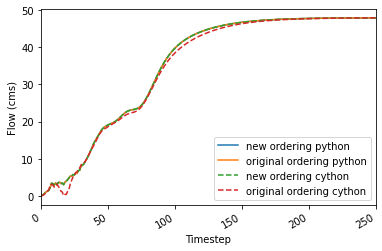

max difference between python-based network routing: 0.0
max difference between cython-based network routing: 3.5859015


In [9]:
link_id = 4186169 # <---- this is the network tailwater segment

plt.plot(flow_mod_py.loc[link_id].values,'-', label = "new ordering python")
plt.plot(flow_og_py.loc[link_id].values,'-', label = "original ordering python")
plt.plot(flow_mod_cy.loc[link_id].values,'--', label = "new ordering cython")
plt.plot(flow_og_cy.loc[link_id].values,'--', label = "original ordering cython")

plt.ylabel("Flow (cms)")
plt.xlabel("Timestep")
plt.legend()
plt.xlim([0,250])
fig = plt.gcf()
fig.patch.set_facecolor('white')
fig.autofmt_xdate()
plt.show()

print("max difference between python-based network routing:", max(abs(flow_mod_py.loc[link_id].values- flow_og_py.loc[link_id].values)))
print("max difference between cython-based network routing:", max(abs(flow_mod_cy.loc[link_id].values- flow_og_cy.loc[link_id].values)))

# Observations
1. The python-based compute_network routines produce the same results
2. The new (modified) cython-based compute_network routine produces the same results as the python routines
3. The odd man out is the original ordering cython computation. 